<a href="https://colab.research.google.com/github/seenu-g/school_of_ai/blob/master/chap5/Basic%20Reduced%20Convolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


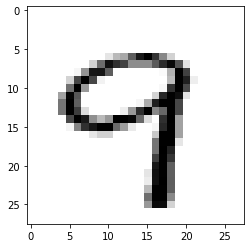

In [0]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape) # Each sample image is 28x28

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

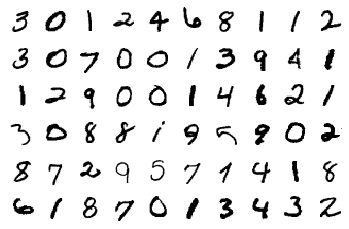

In [0]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
dropout_value = 0.03
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(3, 3), padding=0),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) 
        self.conv_layer2 = nn.Sequential(  
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0),
            nn.BatchNorm2d(num_features=12)
        )
        self.maxpool_layer3 = nn.MaxPool2d(kernel_size=(2,2))
        self.conv_layer4 = nn.Sequential(  
            nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3, 3), padding=0),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )
        self.conv_layer5 = nn.Sequential(  
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0),
            nn.BatchNorm2d(num_features=16)
        )
        self.conv_layer6 = nn.Sequential(  
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )
        self.conv_layer7 = nn.Sequential(  
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0),
            nn.BatchNorm2d(num_features=16)
        )
        self.avgpool_layer8 = nn.AvgPool2d(kernel_size=6)
        self.conv_layer9 = nn.Sequential(  
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0)
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.conv_layer2(x)
        x = self.maxpool_layer3(x)
        x = self.conv_layer4(x)
        x = self.conv_layer5(x)
        x = self.conv_layer6(x)
        x = self.conv_layer7(x)
        x = self.avgpool_layer8(x)
        x = self.conv_layer9(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             120
              ReLU-2           [-1, 12, 26, 26]               0
           Dropout-3           [-1, 12, 26, 26]               0
            Conv2d-4           [-1, 12, 24, 24]           1,308
       BatchNorm2d-5           [-1, 12, 24, 24]              24
         MaxPool2d-6           [-1, 12, 12, 12]               0
            Conv2d-7           [-1, 14, 10, 10]           1,526
              ReLU-8           [-1, 14, 10, 10]               0
           Dropout-9           [-1, 14, 10, 10]               0
           Conv2d-10             [-1, 16, 8, 8]           2,032
      BatchNorm2d-11             [-1, 16, 8, 8]              32
           Conv2d-12             [-1, 16, 8, 8]           2,320
             ReLU-13             [-1, 16, 8, 8]               0
          Dropout-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'epoch={epoch} Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [0]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


epoch=0 Loss=0.24391190707683563 Batch_id=468 Accuracy=90.03: 100%|██████████| 469/469 [00:10<00:00, 45.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0702, Accuracy: 9829/10000 (98.29%)

EPOCH: 1


epoch=1 Loss=0.06231807544827461 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:10<00:00, 45.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0432, Accuracy: 9878/10000 (98.78%)

EPOCH: 2


epoch=2 Loss=0.07091078907251358 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:10<00:00, 43.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0475, Accuracy: 9876/10000 (98.76%)

EPOCH: 3


epoch=3 Loss=0.017322704195976257 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:10<00:00, 44.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0421, Accuracy: 9877/10000 (98.77%)

EPOCH: 4


epoch=4 Loss=0.04702277481555939 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:11<00:00, 42.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9908/10000 (99.08%)

EPOCH: 5


epoch=5 Loss=0.026838937774300575 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:10<00:00, 43.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 9908/10000 (99.08%)

EPOCH: 6


epoch=6 Loss=0.024393081665039062 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:10<00:00, 42.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9898/10000 (98.98%)

EPOCH: 7


epoch=7 Loss=0.010329212062060833 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:10<00:00, 43.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9903/10000 (99.03%)

EPOCH: 8


epoch=8 Loss=0.008634437806904316 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:10<00:00, 43.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9904/10000 (99.04%)

EPOCH: 9


epoch=9 Loss=0.036744993180036545 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:11<00:00, 42.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9920/10000 (99.20%)

EPOCH: 10


epoch=10 Loss=0.014934033155441284 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:10<00:00, 43.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9923/10000 (99.23%)

EPOCH: 11


epoch=11 Loss=0.03295968845486641 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:10<00:00, 43.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9926/10000 (99.26%)

EPOCH: 12


epoch=12 Loss=0.005683595780283213 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:11<00:00, 41.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9926/10000 (99.26%)

EPOCH: 13


epoch=13 Loss=0.012128611095249653 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:10<00:00, 43.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9929/10000 (99.29%)

EPOCH: 14


epoch=14 Loss=0.04399073123931885 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:11<00:00, 42.51it/s]



Test set: Average loss: 0.0241, Accuracy: 9913/10000 (99.13%)



Text(0.5, 1.0, 'Test Accuracy')

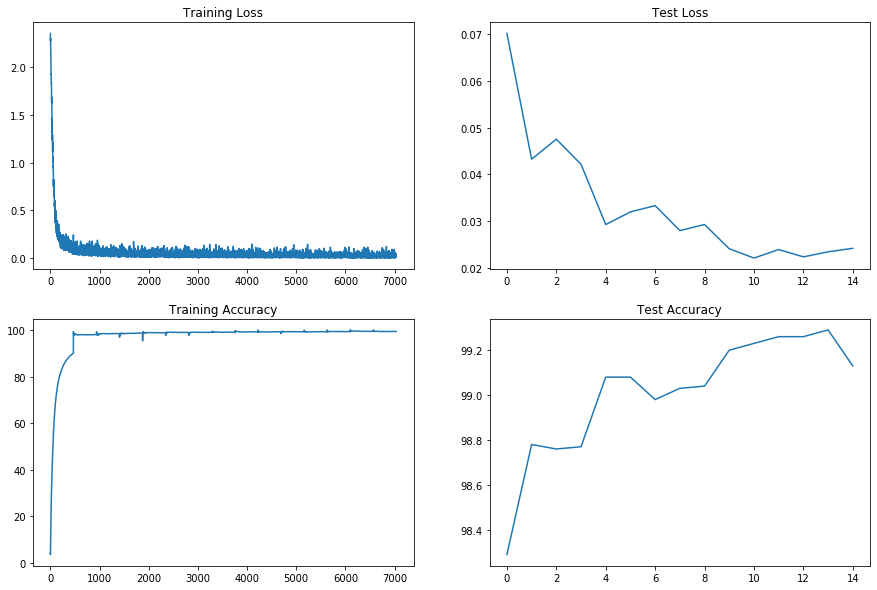

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")